In [1]:
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sea
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline as pipe

from sklearn.model_selection import KFold
from sklearn.linear_model import HuberRegressor
import optuna
import joblib

import warnings
warnings.filterwarnings("ignore")

In [2]:
def format_pl():
  """FLOAT DISPLAY FORMATTING"""
  pl.Config.set_fmt_float("mixed")
  """STRING FORMATTING"""
  pl.Config.set_fmt_str_lengths(50)
  """TABLE FORMATTING"""
  pl.Config.set_tbl_rows(8)
  pl.Config.set_tbl_cols(30)
  pl.Config.set_tbl_width_chars(200)
  pl.Config.set_tbl_cell_alignment("RIGHT")
  pl.Config.set_tbl_hide_dtype_separator(True)
  pl.Config.set_tbl_hide_column_data_types(True)

format_pl()

In [3]:
## Helper functions
eps = 1e-7
logit   = lambda p: np.log(np.clip(p, eps, 1-eps) / (1 - np.clip(p, eps, 1-eps)))
sigmoid = lambda x: 1/(1 + np.exp(-x)) 
RMSE    = lambda y_true, y_pred: np.sqrt(np.mean((y_true - y_pred)**2))

In [4]:
train = pl.read_csv("/kaggle/input/playground-series-s5e10/train.csv")
test  = pd.read_csv("/kaggle/input/playground-series-s5e10/test.csv")
sample_submission = pd.read_csv("/kaggle/input/playground-series-s5e10/sample_submission.csv")

# Original Dataset

In [5]:
train_pd = train.to_pandas().drop(columns=["id"])
bool_features = ["road_signs_present", "public_road", "holiday", "school_season"]


X = train_pd.copy()
X[bool_features] = X[bool_features].astype(np.uint8)

y = X.pop("accident_risk")
y_logit = logit(y)

In [6]:
def cross_validate(model, X, y_logit, n_splits=10, store_oof=True, save_n_models=False, model_prefix=None):
    kfold = KFold(n_splits=n_splits, random_state=3126, shuffle=True)
    rmse  = np.zeros(n_splits)
    if store_oof:
        y_oof = np.zeros_like(y_logit)
    history = {}
    
    for k,(train_idx, val_idx) in enumerate(kfold.split(X)):
        X_train, y_train = X.iloc[train_idx], y_logit[train_idx]
        X_val,   y_val   = X.iloc[val_idx],   y_logit[val_idx]
        
        cloned_model = clone(model)
        cloned_model.fit(X_train, y_train)
        if save_n_models:
            model_filename = f"{model_prefix}_{k+1}.joblib"
            joblib.dump(cloned_model, model_filename)
            
        ## Get logit predictions
        y_pred = cloned_model.predict(X_val)
        ## If store_oof is enabled, stores the oof prediction
        if store_oof:
            y_oof[val_idx] = y_pred
        ## Stores RMSE
        rmse[k] = RMSE(sigmoid(y_val), sigmoid(y_pred))       
        
    history["rmse"] = rmse
    if store_oof:
        history["y_oof"] = y_oof
    return history

In [7]:
cat_features = ['road_type', 'lighting', 'weather', 'time_of_day']
num_features = ["curvature", "speed_limit"]

preprocessor = ColumnTransformer(
    [("categorical", OneHotEncoder(drop="first"), cat_features),
     ("numerical", StandardScaler(), num_features)],
    remainder="passthrough",
    n_jobs=-1
)

In [8]:
# def objective(trial, X, y_logit):
#     alpha    = trial.suggest_float("alpha", .0075, 10.0, log=True)
#     epsilon  = trial.suggest_float("epsilon", 1.0, 2.0)

#     model = pipe(preprocessor,
#                  HuberRegressor(alpha=alpha, epsilon=epsilon, max_iter=1000))
#     history = cross_validate(model, X, y_logit, store_oof=False)
#     return history["rmse"].mean()

# study = optuna.create_study(direction="minimize")  
# study.optimize(lambda trial: objective(trial, X, y_logit), n_trials=100)

In [9]:
# # RMSE: 0.073752
# huber_params = {
#     'alpha':0.08950565488330862, 
#     'epsilon':1.000485972064815
# }

# num_lanes as categorical

In [10]:
X_new = X.copy()
X_new["num_lanes"] = X_new["num_lanes"].astype(object)

cat_features = ['road_type', 'lighting', 'weather', 'time_of_day', 'num_lanes']
num_features = ["curvature", "speed_limit"]

preprocessor = ColumnTransformer(
    [("categorical", OneHotEncoder(drop="first"), cat_features),
     ("numerical", StandardScaler(), num_features)],
    remainder="passthrough",
    n_jobs=-1
)

In [11]:
# def objective(trial, X_new, y_logit):
#     alpha    = trial.suggest_float("alpha", .0075, 10.0, log=True)
#     epsilon  = trial.suggest_float("epsilon", 1.0, 2.0)

#     model = pipe(preprocessor,
#                  HuberRegressor(alpha=alpha, epsilon=epsilon, max_iter=1000))
#     history = cross_validate(model, X_new, y_logit, store_oof=False)
#     return history["rmse"].mean()

# study = optuna.create_study(direction="minimize")  
# study.optimize(lambda trial: objective(trial, X_new, y_logit), n_trials=100)

In [12]:
# RMSE: 0.073749
huber_params = {
    'alpha': 0.2769042530466085, 
    'epsilon': 1.001479326947064
}

# Evaluating HuberRegressor

In [13]:
huber = pipe(
    preprocessor,
    HuberRegressor(**huber_params, max_iter=1000))
history = cross_validate(huber, X_new, y_logit, store_oof=True, save_n_models=True, model_prefix="huber")

In [14]:
history["rmse"].mean()

0.07374949682558274

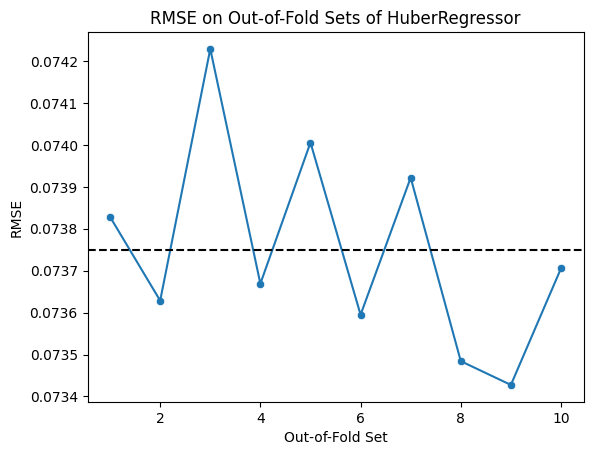

In [15]:
sea.scatterplot(x=np.arange(1,11), y=history["rmse"])
sea.lineplot(x=np.arange(1,11), y=history["rmse"])
plt.axhline(y=history["rmse"].mean(), linestyle="dashed", color="black")
plt.title("RMSE on Out-of-Fold Sets of HuberRegressor")
plt.xlabel("Out-of-Fold Set")
plt.ylabel("RMSE")
plt.show()

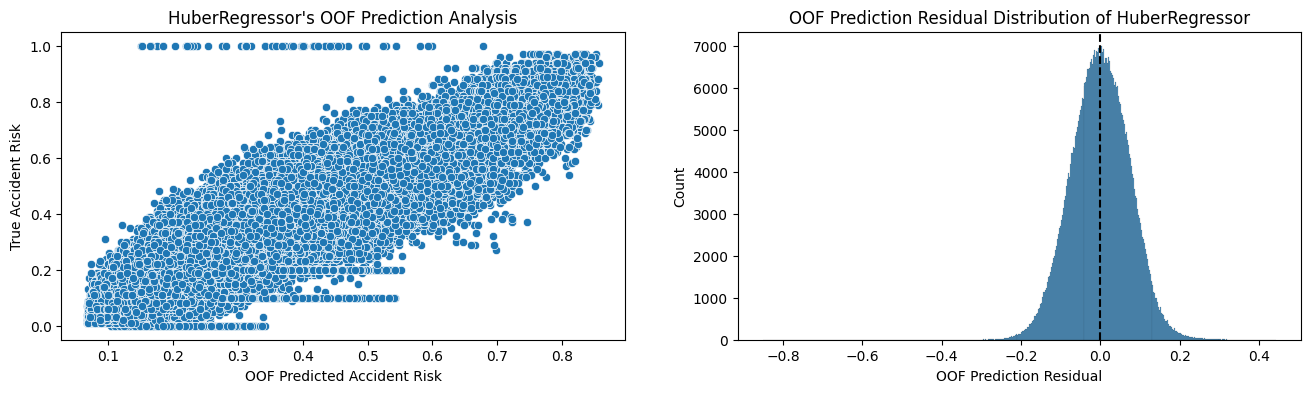

In [16]:
plt.figure(figsize=(16,4))
plt.subplot(121)
sea.scatterplot(x=sigmoid(history["y_oof"]), y=y)
plt.xlabel("OOF Predicted Accident Risk")
plt.ylabel("True Accident Risk")
plt.title("HuberRegressor's OOF Prediction Analysis")

plt.subplot(122)
sea.histplot(sigmoid(history["y_oof"])-y)
plt.axvline(x=(sigmoid(history["y_oof"])-y).mean(), color="black", linestyle="dashed")
plt.xlabel("OOF Prediction Residual")
plt.ylabel("Count")
plt.title("OOF Prediction Residual Distribution of HuberRegressor")

plt.show()

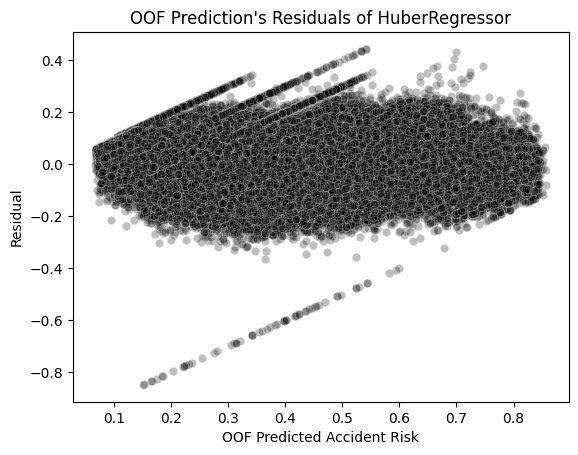

In [17]:
sea.scatterplot(x=sigmoid(history["y_oof"]), y=sigmoid(history["y_oof"])-y, alpha=.25, color="black")
plt.xlabel("OOF Predicted Accident Risk")
plt.ylabel("Residual")
plt.title("OOF Prediction's Residuals of HuberRegressor")
plt.show()

# Prediction on Test Data

In [18]:
test.drop(columns=["id"], inplace=True)
test[bool_features] = test[bool_features].astype(np.uint8)
test["num_lanes"] = test["num_lanes"].astype(object)

y_pred = np.zeros(len(test))
for k in range(1, 11):
    huber = joblib.load(f"/kaggle/working/huber_{k}.joblib")
    y_pred += sigmoid(huber.predict(test))
y_pred /= 10

sample_submission["accident_risk"] = y_pred
sample_submission

,id,accident_risk
0,517754,0.341760
1,517755,0.168083
2,517756,0.199895
3,517757,0.437397
4,517758,0.306202
...,...,...
172580,690334,0.181805
172581,690335,0.560485
172582,690336,0.228080
172583,690337,0.177546


In [19]:
sample_submission.to_csv("submission.csv", index=False)